<a href="https://colab.research.google.com/github/jpedrogama/posicevia06/blob/main/Prova_IA_ICEV_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hackathon Relâmpago - Caçadores de Fraudes

Autores: João Pedro Gama Feitosa, Robson Medeiros Santos

Data: 06/04/2025
Objetivo: Detectar fraudes em lista de compras públicas utilizando Python.

Importações e Carregamento de Dados

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("public_servant_purchases_new.csv")

Definição das Funções

In [142]:
def criar_coluna_hora():
  """
    Cria a coluna 'hora' a partir da data da compra no DataFrame global df.
  """
  df['hora'] = pd.to_datetime(df['data_da_compra']).dt.time

def filtrar_compras_acima_por_valor(compras, valor_minimo=1000):
    """
    Retorna as compras com valor acima do valor mínimo.
    """
    filtro = compras[compras['valor_em_real'] > valor_minimo].copy()
    return filtro


def contar_compras_severas(compras, hora_inicio_str='22:00', hora_fim_str='06:00', valor_minimo=1000):
    """
    Conta quantas compras com valor alto foram feitas fora do horário informado.
    """
    filtro = filtrar_compras_acima_por_valor(compras, valor_minimo) #Retorna somente as compras acima de 1000 com a coluna hora formatada
    hora_inicio = pd.to_datetime(hora_inicio_str, format='%H:%M').time()
    hora_fim = pd.to_datetime(hora_fim_str, format='%H:%M').time()
    resultado = (filtro['hora'] < hora_inicio) | (filtro['hora'] > hora_fim);
    return resultado.sum()


def detectar_compras_duplicadas(compras):
    """
    Verifica se há compras duplicadas e retorna o total encontrado.
    """
    return compras.duplicated().sum()


def verificar_valores_suspeitos(compras):
    """
    Verifica quantas compras têm valor acima de 1000 e retorna o total.
    """
    return (compras['valor_em_real'] > 1000).sum() #df[df['valor_em_real'] > 1000].sum()


def compras_fora_de_horario(compras):
    """
    Verifica quantas compras foram feitas fora do horário comercial.
    """
    compras = compras.copy()
    hora_inicio = pd.to_datetime('08:00', format='%H:%M').time()
    hora_fim = pd.to_datetime('18:00', format='%H:%M').time()
    compras['hora'] = pd.to_datetime(compras['data_da_compra']).dt.time
    fora_do_horario = (compras['hora'] < hora_inicio) | (compras['hora'] > hora_fim)
    return fora_do_horario.sum();


def organizar_por_servidor(compras):
    """
    Cria um dicionário com os nomes dos servidores e os itens comprados por cada um.
    """
    group = df[['nome_do_funcionario', 'item_comprado']].groupby('nome_do_funcionario');
    organizado = {}
    for chave, grupo_dados in group:
      organizado[list(grupo_dados['nome_do_funcionario'])[0]] = list(grupo_dados['item_comprado'])
    return organizado


def total_fraudes(compras):
    """
    Soma o total de fraudes encontradas: duplicadas, acima do valor e fora do horário.
    """
    return compras_fora_de_horario(compras) + verificar_valores_suspeitos(compras) + detectar_compras_duplicadas(compras)

def por_tipo_fraude(compras):
    """
    Retorna um dicionário com a quantidade de fraudes por tipo.
    """
    return {"Compras duplicadas": int(detectar_compras_duplicadas(compras)), "Acima do limite": int(verificar_valores_suspeitos(compras)), "Fora do horário comercial": int(compras_fora_de_horario(compras))}



def compras_dados_inconsistente(compras):
    """
    Conta quantos dados estão errados no DataFrame de compras.

    Verifica nomes que não são só letras, valores que não são números
    e datas inválidas. Retorna um dicionário com essas quantidades.
    """
    nome_inconsistente = compras['nome_do_funcionario'].apply(
        lambda x: not isinstance(x, str) or not x.isalpha()
    ).sum()
    valor_inconsistente = compras['valor_em_real'].apply(
        lambda x: not isinstance(x, (int, float))
    ).sum()
    datas_convertidas = pd.to_datetime(compras['data_da_compra'], errors='coerce')
    data_inconsistente = datas_convertidas.isna().sum()

    return {
        'Nome inconsistente': int(nome_inconsistente),
        'Valor inconsistente': int(valor_inconsistente),
        'Data inconsistente': int(data_inconsistente)
    }

def gerar_relatorio(por_tipo_fraude):
    df = pd.DataFrame({
        'categoria': por_tipo_fraude.keys(),
        'quantidade': por_tipo_fraude.values()
    })
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x='categoria', y='quantidade')

    # Adicionar os valores no topo das barras
    for index, row in df.iterrows():
        plt.text(index, row['quantidade'], str(row['quantidade']), ha='center')

    # Estilização
    plt.title('Ocorrencias por categoria de fraude')
    plt.ylabel('Quantidade')
    plt.xlabel('Categoria')
    plt.tight_layout()
    # Mostrar o gráfico
    plt.show()

Execução da Análise e Visualização

Iniciando detecção de fraudes...
Dados preparados com sucesso!

--- ANÁLISE DE COMPRAS SUSPEITAS ---
Quantidade de compras Nível de severidade alta: 929
Quantidade de compras Nível de severidade média: 828

--- INCONSISTÊNCIAS NOS DADOS ---
{'Nome inconsistente': 4260, 'Valor inconsistente': 0, 'Data inconsistente': 0}

--- TIPOS DE FRAUDE DETECTADOS ---
- Compras duplicadas: 0
- Acima do limite: 929
- Fora do horário comercial: 1297

Total de fraudes: 2226

Gerando gráfico de fraudes...


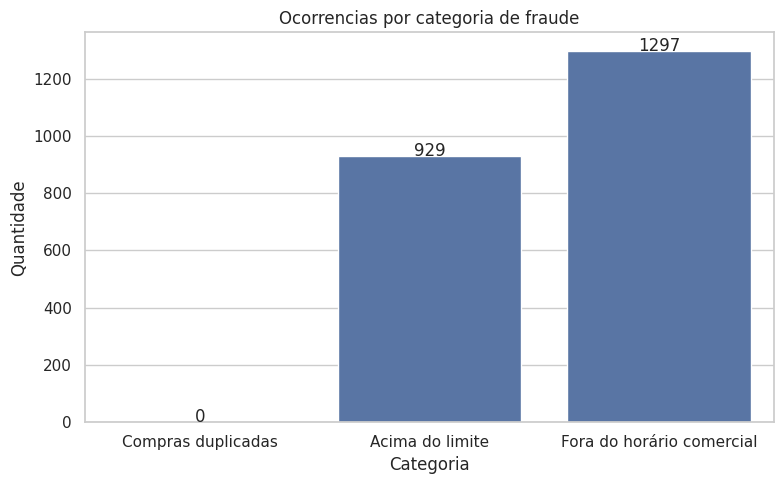

In [147]:
# Preparação inicial
print("Iniciando detecção de fraudes...")
criar_coluna_hora()
print("Dados preparados com sucesso!\n")

# Análise de compras suspeitas por severidade
print("--- ANÁLISE DE COMPRAS SUSPEITAS ---")
print(f"Quantidade de compras Nível de severidade alta: {contar_compras_severas(df)}")
print(f"Quantidade de compras Nível de severidade média: {contar_compras_severas(df, '18:00','21:59')}")

# Análise de inconsistências nos dados
print("\n--- INCONSISTÊNCIAS NOS DADOS ---")
inconsistencias = compras_dados_inconsistente(df)
print(inconsistencias)

# Análise e visualização de tipos de fraude
print("\n--- TIPOS DE FRAUDE DETECTADOS ---")
fraudes = por_tipo_fraude(df)
for tipo, qtd in fraudes.items():
    print(f"- {tipo}: {qtd}")
print(f"\nTotal de fraudes: {total_fraudes(df)}")

# Gerar relatório visual com as fraudes encontradas
print("\nGerando gráfico de fraudes...")
gerar_relatorio(por_tipo_fraude(df))